# Use GPLVM on the cell type proportions to smooth the time since infection to get a more accurately distributed training set for my MTGPR model

In [1]:
import anndata
import scanpy as sc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import multiprocessing
from multiprocessing import Pool
import tqdm
import time
from time import sleep
import warnings

import pandas as pd
import torch
from torch.nn import Parameter
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats
import gpytorch

import scvi 
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

torch.cuda.is_available() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

Global seed set to 0


In [2]:
#adata = anndata.read_h5ad('/nfs/team205/ld21/renal/renal_covid.h5ad')

In [3]:
dfMeta = pd.read_csv('/nfs/team205/rl21/projects/RL007_challengeStudy/df_pbmc_rawGex.obs.withCelltypistPreds.csv')

In [4]:
#dfMeta = dfMeta.loc[:,["celltypist_prediction","patient_id","time_point","covid_status"]]
# For some reason this becomes neccesary when saving/loading .obs
for i in dfMeta.columns:
    if (dfMeta[i].dtypes=="object"):
        dfMeta[i] = dfMeta[i].astype("string")

In [5]:
%%R -i dfMeta
#head(dfMeta)

NULL


In [6]:
%%R -o cell_state_freqs
dfMeta <- dfMeta[dfMeta$covid_status=="Infected",]
#cell_state_freqs <- as.data.frame.matrix(table(dfMeta$celltypist_prediction,paste0(dfMeta$patient_id,"_",gsub("D","",dfMeta$time_point))))
cell_state_freqs <- as.data.frame.matrix(table(dfMeta$celltypist_prediction,paste0(dfMeta$orig.ident,"_",dfMeta$patient_id,"_",gsub("D","",dfMeta$time_point))))
#head(cell_state_freqs)

In [7]:
%%R -i cell_state_freqs -o cell_state_props -o cell_states
cell_states <- rownames(cell_state_freqs)
cell_state_props <- as.data.frame(t(apply(cell_state_freqs,2,function(x) x/sum(x))))

compartment_list <- list(Naive_T = c("T CD8 Naive RTE", "T CD8 Naive", "T CD8 Naive IFN stim", "T CD4 Naive",  "T CD4 Naive IFN stim", "T CD4 Naive RTE"),
                         Naive_B = c("B Naive", "B Naive IFN stim"),
                         B = c("Plasma Cell", "Plasmablast","B Non-Switched Memory", "B Switched Memory",  "B Non-Switched Memory IFN stim", "B Non-Switched FCRL3+",  "B Switched Memory IFN stim", "B Switched FCRL3+"), 
                         "T CD4" = c("T CD4 Helper 0", "T CD4 Follicular Helper", "T CD4 Helper 2",  "T CD4 Helper 0 IFN stim", "T CD4 Helper 2 IFN stim",  "T CD4 Helper 1", "T CD4 Helper 17", "T CD4 Activated CTL",  "T CD4 Helper 1 IFN stim", "T CD4 CTL", "T CD4 Helper 1 Cycling",  "T CD4 Activated CTL Cycling","T Double Negative", "T Double Negative Cycling"), 
                         "T Reg" = c("T Reg CM", "T Reg EM",  "T Reg EM Cycling", "T Reg CM GZMK+ IFNG+", "T Reg CM Cycling" ), 
                         "T CD8" = c("T CD8 EM", "T CD8 EMRA", "NKT",  "T CD8 Activated CTL Cycling", "T CD8 CTL", "T CD8 CM",  "T CD8 CTL Cycling", "T CD8 Activated CTL",  "T CD8 CTL IFN stim", "T CD8 CM IFN stim"), 
                         NK = c("NK", "NK IFN stim",  "NK Cycling","ILC",      "ILC IFN stim","NK CD56+", "NK CD56+ Cycling"), 
                         Monocyte = c("Monocyte CD14+", "Monocyte CD14+ IFN stim",  "Monocyte CD16+", "Monocyte CD14+ Pro-inflammatory", "Monocyte CD16+ IFN stim",  "Monocyte CD16+ C1+"),
                         DC = c("pDC",  "cDC2 IFN stim", "cDC2 CD14+", "cDC2", "pDC IFN stim", "cDC1",  "cDC1 IFN stim", "AS-DC", "cDC1 Cycling","Haematopoietic Progenitor CD34+/CD38-", "Haematopoietic Progenitor CD34+/CD38+",  "Haematopoietic Progenitor CD34+/CD38+ IFN stim", "Lymphoid Progenitor",  "Eosinophil/Basophil/Mast Progenitor", "Myeloid Progenitor"),
                         "T G/D" = c("T G/D non-Dv2/Gv9", "T G/D CM", "T G/D Immature",  "T G/D EM", "T G/D CM IFN stim", "T G/D Immature RTE"), 
                         "T MAI" = c("T MAI Activated",  "T MAI"))


#compartment_list <- list(B = c("Plasma Cell", "Plasmablast","B Non-Switched Memory", "B Naive", "B Switched Memory",  "B Naive IFN stim", "B Non-Switched Memory IFN stim", "B Non-Switched FCRL3+",  "B Switched Memory IFN stim", "B Switched FCRL3+"), 
#                         "T CD4" = c("T CD4 Naive",  "T CD4 Helper 0", "T CD4 Follicular Helper", "T CD4 Helper 2",  "T CD4 Naive IFN stim", "T CD4 Helper 0 IFN stim", "T CD4 Helper 2 IFN stim",  "T CD4 Helper 1", "T CD4 Helper 17", "T CD4 Naive RTE", "T CD4 Activated CTL",  "T CD4 Helper 1 IFN stim", "T CD4 CTL", "T CD4 Helper 1 Cycling",  "T CD4 Activated CTL Cycling","T Double Negative", "T Double Negative Cycling"), 
#                         "T Reg" = c("T Reg CM", "T Reg EM",  "T Reg EM Cycling", "T Reg CM GZMK+ IFNG+", "T Reg CM Cycling" ), 
#                         "T CD8" = c("T CD8 Naive", "T CD8 EM", "T CD8 EMRA", "NKT",  "T CD8 Activated CTL Cycling", "T CD8 CTL", "T CD8 CM", "T CD8 Naive IFN stim",  "T CD8 Naive RTE", "T CD8 CTL Cycling", "T CD8 Activated CTL",  "T CD8 CTL IFN stim", "T CD8 CM IFN stim"), 
#                         NK = c("NK", "NK IFN stim",  "NK Cycling","ILC",      "ILC IFN stim"), 
#                         Monocyte = c("Monocyte CD14+", "Monocyte CD14+ IFN stim",  "Monocyte CD16+", "Monocyte CD14+ Pro-inflammatory", "Monocyte CD16+ IFN stim",  "Monocyte CD16+ C1+"), "NK CD56+" = c("NK CD56+", "NK CD56+ Cycling" ), 
#                         "T G/D" = c("T G/D non-Dv2/Gv9", "T G/D CM", "T G/D Immature",  "T G/D EM", "T G/D CM IFN stim", "T G/D Immature RTE"), 
#                         DC = c("pDC",  "cDC2 IFN stim", "cDC2 CD14+", "cDC2", "pDC IFN stim", "cDC1",  "cDC1 IFN stim", "AS-DC", "cDC1 Cycling","Haematopoietic Progenitor CD34+/CD38-", "Haematopoietic Progenitor CD34+/CD38+",  "Haematopoietic Progenitor CD34+/CD38+ IFN stim", "Lymphoid Progenitor",  "Eosinophil/Basophil/Mast Progenitor", "Myeloid Progenitor"), 
#                         "T MAI" = c("T MAI Activated",  "T MAI"))
for (compartment in names(compartment_list)) { cell_state_props[,compartment_list[[compartment]]] <- as.data.frame(t(apply(cell_state_freqs[compartment_list[[compartment]],],2,function(x) x/sum(x)))) }
cell_state_props <- -log10(cell_state_props+.01)

In [8]:
cell_state_props[np.isnan(cell_state_props)] = 2

In [9]:
%%R -i cell_state_props -o time_numeric
time_numeric <- as.numeric(gsub(".*_(.*)","\\1",rownames(cell_state_props)))
#time_numeric <- log2(time_numeric+3)
time_numeric <- (time_numeric+2)^.5

In [10]:
time_numeric = torch.tensor(time_numeric, dtype=torch.float32)

In [11]:
y = torch.tensor(cell_state_props.to_numpy(), dtype=torch.get_default_dtype())

In [12]:
y = y.t()

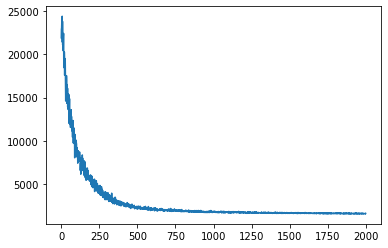

In [13]:
pyro.set_rng_seed(1)
n_latent_dim = 1

# X Latent dimensions initialisation 
X_prior_mean = torch.zeros(y.size(1), n_latent_dim)  # shape: cells x 2
X_prior_mean[:, 0] = time_numeric 

kernel = gp.kernels.RBF(input_dim=n_latent_dim, lengthscale=torch.ones(n_latent_dim))

# we clone here so that we don't change our prior during the course of training
X = Parameter(X_prior_mean.clone())

# SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
#Xu = stats.resample(X_prior_mean.clone(), 2000)
noise_tensor = torch.tensor(0.01)

#gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=noise_tensor, jitter=1e-5)
gplvm = gp.models.GPRegression(X, y, kernel, noise=noise_tensor, jitter=1e-5)
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)
losses = gp.util.train(gplvm, num_steps=2000)
#losses = gp.util.train(gplvm, num_steps=20000)

# loss curve
plt.plot(losses)
plt.show()
gplvm.mode = "guide"
X = gplvm.X  # draw a sample from the guide of the variable X


In [14]:
predicted_time = X.detach().numpy()[:,0]
#latentVar2 = X.detach().numpy()[:,1]
real_time = time_numeric.detach().numpy()

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



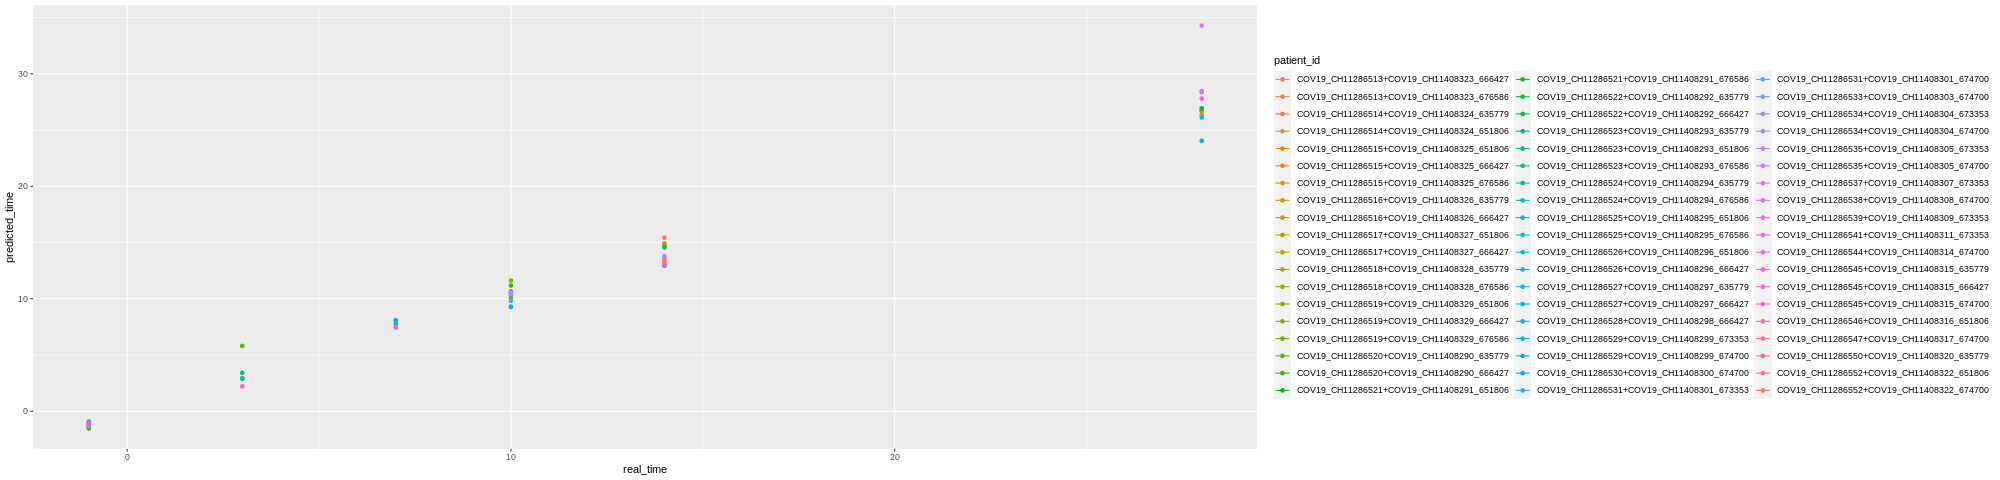

In [15]:
%%R -i predicted_time -i real_time -w 2000
#-i latentVar2
library(ggplot2)
#myDf <- data.frame(sample_id=rownames(cell_state_props), predicted_time=predicted_time^2-2, real_time=real_time^2-2, latentVar2=latentVar2)
myDf <- data.frame(sample_id=rownames(cell_state_props), predicted_time=predicted_time^2-2, real_time=real_time^2-2)
myDf$patient_id <- gsub("(.*)_(.*)","\\1",myDf$sample_id)

ggplot(myDf,aes(real_time,predicted_time,col=patient_id)) + geom_point() + geom_line()
#ggplot(myDf,aes(predicted_time,latentVar2,col=patient_id)) + geom_point() + geom_line()
#plot((predicted_time^2-2),real_time^2-2)

In [16]:
%%R
cat(deparse(myDf))


structure(list(sample_id = c("COV19_CH11286513+COV19_CH11408323_666427_28",  "COV19_CH11286513+COV19_CH11408323_676586_10", "COV19_CH11286514+COV19_CH11408324_635779_14",  "COV19_CH11286514+COV19_CH11408324_651806_28", "COV19_CH11286515+COV19_CH11408325_651806_10",  "COV19_CH11286515+COV19_CH11408325_666427_-1", "COV19_CH11286515+COV19_CH11408325_676586_14",  "COV19_CH11286516+COV19_CH11408326_635779_28", "COV19_CH11286516+COV19_CH11408326_666427_3",  "COV19_CH11286517+COV19_CH11408327_651806_28", "COV19_CH11286517+COV19_CH11408327_666427_-1",  "COV19_CH11286518+COV19_CH11408328_635779_14", "COV19_CH11286518+COV19_CH11408328_676586_14",  "COV19_CH11286519+COV19_CH11408329_651806_10", "COV19_CH11286519+COV19_CH11408329_666427_3",  "COV19_CH11286519+COV19_CH11408329_676586_10", "COV19_CH11286520+COV19_CH11408290_635779_3",  "COV19_CH11286520+COV19_CH11408290_666427_10", "COV19_CH11286521+COV19_CH11408291_651806_-1",  "COV19_CH11286521+COV19_CH11408291_676586_28", "COV19_CH11286522+COV19_